In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import SequentialPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_loss(cues_sim, cues_emp, max_cues=18, method='chi2'):
    total_loss = 0
    if method=='chi2':
        bins = np.arange(0.0, 2*max_cues+3, 3)
        hist_cues_sim = np.histogram(cues_sim, bins=bins)[0]
        hist_cues_emp = np.histogram(cues_emp, bins=bins)[0]
        normed_hist_cues_sim = hist_cues_sim / len(cues_sim)
        normed_hist_cues_emp = hist_cues_emp / len(cues_emp)
        loss = chi_squared_distance(normed_hist_cues_sim, normed_hist_cues_emp)
        # print(f"loss {loss}")
        total_loss += loss
    if method=='mean':
        raise  # todo
    return total_loss

In [3]:
def sequential_trial(dP, ramp=0.1, threshold=0.4, relative=1, perception_seed=0, network_seed=0,
                 dt=0.001, cues_max=18, dt_sample=0.5, legend=False, name="sequential"):

    inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
    inputs.create(dP=dP)
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0.01):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > cues_max*dt_sample:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
    correct = 1 if choice==net.inputs.correct else 0

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    for a in range(2):
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], label=f"Evidence {a}") 
    for a in range(2):
        axes[0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {a}", linestyle="--") 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", title="Decision Criteria")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left')
        leg.get_texts()[net.inputs.correct].set_color("lime" if correct else "red")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

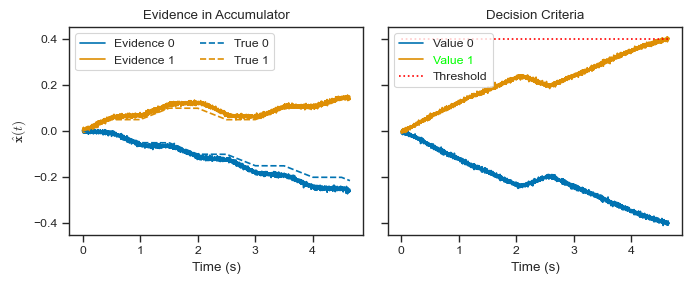

In [6]:
sequential_trial(dP=0.4, ramp=0.1, threshold=0.4, legend=True)

In [4]:
def sequential_agent(dP, ramp=0.1, threshold=0.4, relative=1, perception_seed=0, network_seed=0,
                 experiment_time=60.0, dt=0.001, cues_max=18, dt_sample=0.5, name="sequential_agent"):

    inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
    dfs = []
    columns = ('agent', 'trial', 'accuracy', 'RT')
    total_time = 0
    trial = 0
    while total_time < experiment_time:
        print(f"trial {trial}")
        inputs.create(dP=dP)
        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > cues_max*dt_sample:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
        dfs.append(pd.DataFrame([['test agent', trial, 100*correct, RT]], columns=columns))
        total_time += RT
        trial += 1

    data = pd.concat(dfs, ignore_index=True)
    print(f"{trial} trials completed in {experiment_time} seconds; mean accuracy {data['accuracy'].mean()}")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((3.5, 3)))
    sns.histplot(data=data, x="RT", stat="percent", palette=palette[0], ax=ax)
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

In [8]:
# sequential_agent(dP=0.4, ramp=0.3, threshold=0.8, experiment_time=120.0)

In [5]:
def scan_dP(dPs=[0.4, 0.2, 0.1], ramp=0.1, threshold=0.4, relative=1, perception_seed=0, pid=0,
                 nNeurons=200, experiment_time=60.0, dt=0.001, cues_max=12, dt_sample=0.5, name="scan_dP", load=False):

    if not load:
        dfs = []
        columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues')
        for dP in dPs:
            inputs = SequentialPerception(seed=int(dP*10), dt_sample=dt_sample)
            inputs.create(dP=dP)
            total_time = 0
            trial = 0
            while total_time < experiment_time:
                net = build_network(inputs, seed=pid, ramp=ramp, threshold=threshold, nNeurons=nNeurons, relative=relative)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                RT = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > cues_max*dt_sample:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = 1 if choice==net.inputs.correct else 0
                cues = int(RT/dt_sample)+1
                print(f"trial {trial}, dP {dP}, elapsed time {total_time}, cues {cues}")
                dfs.append(pd.DataFrame([['model', '0', dP, trial, 100*correct, cues]], columns=columns))
                total_time += RT
                trial += 1
        # print(f"{trial} trials completed in {experiment_time} seconds; mean accuracy {data['accuracy'].mean()}")
        sim = pd.concat(dfs, ignore_index=True)
        sim.to_pickle(f"data/{name}_{pid}.pkl")
    else:
        sim = pd.read_pickle(f"data/{name}_{pid}.pkl")

    emp = pd.read_pickle("data/fiedler2021.pkl").query("max_cues==@cues_max")
    strpid = str(pid)
    data = pd.concat([sim, emp.query("id==@strpid")], ignore_index=True)
    for dP in dPs:
        sim_cues = data.query("type=='model' & dP==@dP")['cues'].to_numpy()
        emp_cues = data.query("type=='human' & dP==@dP")['cues'].to_numpy()
        loss = get_loss(sim_cues, emp_cues)
        print(f"dP {dP}, loss {loss}")

    fig = sns.FacetGrid(data, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=1.5, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=np.arange(0, 2*cues_max+3, 3), common_norm=False)
    fig.set_xlabels("Cues Sampled Per Trial")
    fig.add_legend()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0, dP 0.1, elapsed time 0, cues 12
trial 1, dP 0.1, elapsed time 5.864, cues 17
trial 2, dP 0.1, elapsed time 14.117999999999999, cues 6
trial 3, dP 0.1, elapsed time 16.958, cues 19
trial 4, dP 0.1, elapsed time 25.958999999999996, cues 11
trial 5, dP 0.1, elapsed time 31.089999999999996, cues 5
trial 6, dP 0.1, elapsed time 33.43899999999999, cues 5
trial 7, dP 0.1, elapsed time 35.809999999999995, cues 13
trial 8, dP 0.1, elapsed time 42.211, cues 10
trial 9, dP 0.1, elapsed time 47.076, cues 7
trial 10, dP 0.1, elapsed time 50.113, cues 7
trial 11, dP 0.1, elapsed time 53.15, cues 19
trial 12, dP 0.1, elapsed time 62.150999999999996, cues 11
trial 13, dP 0.1, elapsed time 67.36, cues 6
trial 14, dP 0.1, elapsed time 70.2, cues 9
trial 15, dP 0.1, elapsed time 74.53, cues 7
trial 16, dP 0.1, elapsed time 77.578, cues 6
trial 17, dP 0.1, elapsed time 80.42, cues 17
trial 18, dP 0.1, elapsed time 88.886, cues 11
trial 19, dP 0.1, elapsed time 93.937, cues 10
trial 20, dP 0.1, el

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 28, dP 0.1, elapsed time 139.982, cues 5
trial 29, dP 0.1, elapsed time 142.353, cues 13
trial 30, dP 0.1, elapsed time 148.841, cues 6


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 31, dP 0.1, elapsed time 151.738, cues 8
trial 32, dP 0.1, elapsed time 155.503, cues 9
trial 33, dP 0.1, elapsed time 159.767, cues 11


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 34, dP 0.1, elapsed time 164.945, cues 7
trial 35, dP 0.1, elapsed time 167.993, cues 10
trial 36, dP 0.1, elapsed time 172.847, cues 18
trial 37, dP 0.1, elapsed time 181.82000000000002, cues 9
trial 38, dP 0.1, elapsed time 186.14400000000003, cues 9
trial 39, dP 0.1, elapsed time 190.46800000000005, cues 5
trial 40, dP 0.1, elapsed time 192.79900000000004, cues 6
trial 41, dP 0.1, elapsed time 195.73000000000005, cues 6
trial 42, dP 0.1, elapsed time 198.57000000000005, cues 5
trial 43, dP 0.1, elapsed time 200.91900000000004, cues 5
trial 44, dP 0.1, elapsed time 203.26800000000003, cues 6
trial 45, dP 0.1, elapsed time 206.19900000000004, cues 5
trial 46, dP 0.1, elapsed time 208.55500000000004, cues 9
trial 47, dP 0.1, elapsed time 212.85700000000003, cues 5
trial 48, dP 0.1, elapsed time 215.17700000000002, cues 7
trial 49, dP 0.1, elapsed time 218.21400000000003, cues 8
trial 50, dP 0.1, elapsed time 221.84700000000004, cues 8
trial 51, dP 0.1, elapsed time 225.6960000000

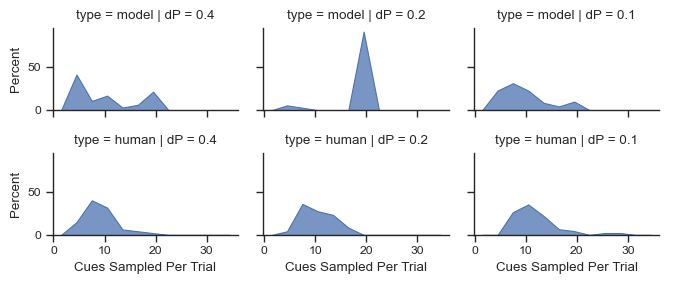

In [6]:
scan_dP(dPs=[0.1, 0.2, 0.4], experiment_time=60.0*5, ramp=0.67, relative=0.12, threshold=0.83, pid=1, cues_max=18, load=False)

In [40]:
def remake_fiedler():
    emp = pd.read_pickle("data/empirical.pkl")
    dfs = []
    columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues', 'max_cues')
    for i, pid in enumerate(emp['participant_id'].unique()):
        for dP in [0.4, 0.2, 0.1]:
            # print(f"pid {pid}, dP {dP}")
            subdata = emp.query("participant_id==@pid & delta==@dP")
            trial = 0
            for index, row in subdata.iterrows():
                dfs.append(pd.DataFrame([["human", f"{i}", dP, trial, 100*row['correct'], row['cues'], row['maxSamples']]], columns=columns))
                trial += 1
    df = pd.concat(dfs, ignore_index=True)
    df.to_pickle("data/fiedler2021.pkl")

In [41]:
remake_fiedler()

In [ ]:
def condense_fiedler():
    dfs = []
    columns = ('type', 'id', 'dP', 'mean cues', 'var cues', 'mean acc', 'var acc')
    emp = pd.read_pickle("data/fiedler2021.pkl")
    for pid in emp['id'].unique():
        for dP in [0.4, 0.2, 0.1]:
            subdata = emp.query("id==@pid & dP==@dP")
            mean_cues = subdata['cues'].mean()
            var_cues = subdata['cues'].std()
            mean_acc = subdata['accuracy'].mean()
            var_acc = subdata['accuracy'].std()
            dfs.append(pd.DataFrame([['human', pid, dP, mean_cues, var_cues, mean_acc, var_acc]], columns=columns))
    new_emp = pd.concat(dfs, ignore_index=True)
    new_emp.to_pickle("data/fiedler2021_condensed.pkl")

In [ ]:
def plot_condensed():
    new_emp = read_pickle("data/fiedler2021_condensed.pkl")
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=((7,2)))
    for i, dP in enumerate([0.4, 0.2, 0.1]):
        subdata = new_emp.query("dP==@dP")
        x = subdata['mean cues'].to_numpy()
        y = subdata['mean acc'].to_numpy()
        xerr = subdata['var cues'].to_numpy()
        yerr = subdata['var acc'].to_numpy()
        axes[i].errorbar(x, y, xerr=xerr, yerr=0*yerr, fmt="o")
    plt.tight_layout()

    fig = sns.FacetGrid(new_emp, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1)
    fig.map_dataframe(sns.scatterplot, x="mean cues", y="mean acc")
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(yticks=[50, 60, 70, 80, 90, 100])
    fig.add_legend()
    fig.savefig(f"plots/facet2.svg")
    fig.savefig(f"plots/facet2.png", dpi=600)

In [120]:
def agent_population(nAgents, dPs=[0.4, 0.2, 0.1], ramps=[0.2, 0.4], thresholds=[0.8, 1.0], relative=1, perception_seed=0, network_seed=0,
                 experiment_time=60.0, dt=0.001, cues_max=18, dt_sample=0.5, name="agent_population", load=False):

    rng = np.random.RandomState(seed=perception_seed)
    if not load:
        dfs = []
        for agent in range(nAgents):
            ramp = rng.uniform(ramps[0], ramps[1])
            threshold = rng.uniform(thresholds[0], thresholds[1])
            inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
            columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues')
            for dP in dPs:
                inputs.create(dP=dP)
                total_time = 0
                trial = 0
                while total_time < experiment_time:
                    print(f"trial {trial}, dP {dP}, agent {agent}")
                    net = build_network(inputs, seed=agent, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > cues_max*dt_sample:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = 1 if choice==net.inputs.correct else 0
                    cues = int(RT/dt_sample)+1
                    dfs.append(pd.DataFrame([['model', agent, dP, trial, 100*correct, cues]], columns=columns))
                    total_time += RT
                    trial += 1
        sim = pd.concat(dfs, ignore_index=True)
        sim.to_pickle("data/agent_population.pkl")
    else:
        sim = pd.read_pickle("data/agent_population.pkl")

    dfs = []
    columns = ('type', 'id', 'dP', 'mean cues', 'var cues', 'mean acc', 'var acc')
    emp = pd.read_pickle("data/fiedler2021_new.pkl")
    combined = pd.concat([sim, emp], ignore_index=True)    
    for type in ['model', 'human']:
        for pid in combined.query("type==@type")['id'].unique():
            for dP in [0.4, 0.2, 0.1]:
                subdata = combined.query("id==@pid & dP==@dP")
                mean_cues = subdata['cues'].mean()
                var_cues = subdata['cues'].std()
                mean_acc = subdata['accuracy'].mean()
                var_acc = subdata['accuracy'].std()
                dfs.append(pd.DataFrame([[type, pid, dP, mean_cues, var_cues, mean_acc, var_acc]], columns=columns))
    new_combined = pd.concat(dfs, ignore_index=True)
    new_combined.to_pickle("data/population_combined.pkl")

    fig = sns.FacetGrid(new_combined, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1)
    fig.map_dataframe(sns.scatterplot, x="mean cues", y="mean acc")
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(yticks=[50, 60, 70, 80, 90, 100])
    fig.add_legend()
    fig.savefig(f"plots/population_combined.svg")
    fig.savefig(f"plots/population_combined.png", dpi=600)

trial 0, dP 0.4, agent 0
trial 1, dP 0.4, agent 0
trial 2, dP 0.4, agent 0
trial 3, dP 0.4, agent 0
trial 4, dP 0.4, agent 0
trial 5, dP 0.4, agent 0
trial 6, dP 0.4, agent 0
trial 7, dP 0.4, agent 0
trial 8, dP 0.4, agent 0
trial 9, dP 0.4, agent 0
trial 10, dP 0.4, agent 0
trial 11, dP 0.4, agent 0
trial 12, dP 0.4, agent 0
trial 13, dP 0.4, agent 0
trial 14, dP 0.4, agent 0
trial 15, dP 0.4, agent 0
trial 16, dP 0.4, agent 0
trial 17, dP 0.4, agent 0
trial 18, dP 0.4, agent 0
trial 19, dP 0.4, agent 0
trial 0, dP 0.2, agent 0
trial 1, dP 0.2, agent 0
trial 2, dP 0.2, agent 0
trial 3, dP 0.2, agent 0
trial 4, dP 0.2, agent 0
trial 5, dP 0.2, agent 0
trial 6, dP 0.2, agent 0
trial 7, dP 0.2, agent 0
trial 8, dP 0.2, agent 0
trial 9, dP 0.2, agent 0
trial 10, dP 0.2, agent 0
trial 11, dP 0.2, agent 0
trial 12, dP 0.2, agent 0
trial 13, dP 0.2, agent 0
trial 14, dP 0.2, agent 0
trial 15, dP 0.2, agent 0
trial 0, dP 0.1, agent 0
trial 1, dP 0.1, agent 0
trial 2, dP 0.1, agent 0
trial 3, 

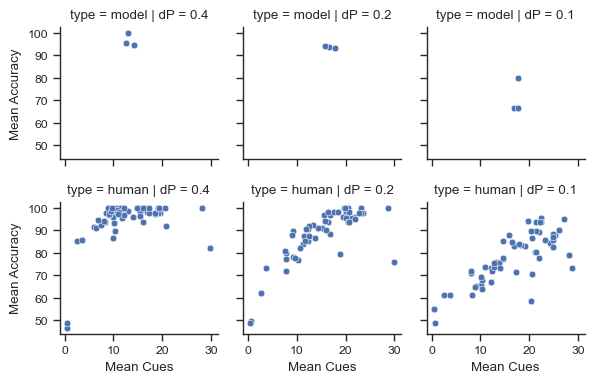

In [121]:
agent_population(nAgents=3, experiment_time=120, load=False)

trial 0, dP 0.4, agent 0
trial 1, dP 0.4, agent 0
trial 2, dP 0.4, agent 0
trial 3, dP 0.4, agent 0
trial 4, dP 0.4, agent 0
trial 5, dP 0.4, agent 0
trial 6, dP 0.4, agent 0
trial 7, dP 0.4, agent 0
trial 8, dP 0.4, agent 0
trial 9, dP 0.4, agent 0
trial 10, dP 0.4, agent 0
trial 11, dP 0.4, agent 0
trial 12, dP 0.4, agent 0
trial 13, dP 0.4, agent 0
trial 14, dP 0.4, agent 0
trial 15, dP 0.4, agent 0
trial 16, dP 0.4, agent 0
trial 17, dP 0.4, agent 0
trial 0, dP 0.2, agent 0
trial 1, dP 0.2, agent 0
trial 2, dP 0.2, agent 0
trial 3, dP 0.2, agent 0
trial 4, dP 0.2, agent 0
trial 5, dP 0.2, agent 0
trial 6, dP 0.2, agent 0
trial 7, dP 0.2, agent 0
trial 8, dP 0.2, agent 0
trial 9, dP 0.2, agent 0
trial 10, dP 0.2, agent 0
trial 11, dP 0.2, agent 0
trial 12, dP 0.2, agent 0
trial 13, dP 0.2, agent 0
trial 0, dP 0.1, agent 0
trial 1, dP 0.1, agent 0
trial 2, dP 0.1, agent 0
trial 3, dP 0.1, agent 0
trial 4, dP 0.1, agent 0
trial 5, dP 0.1, agent 0
trial 6, dP 0.1, agent 0
trial 7, dP 0

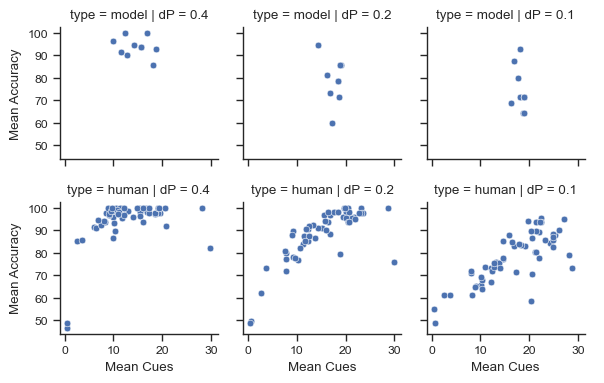

In [123]:
agent_population(nAgents=10, experiment_time=120, load=False, thresholds=[0.6, 1.2], ramps=[0.2, 0.4])